In [1]:
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image


import random, glob, logging
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from preprocess import is_img, parse_fake_path
from dataset import FakeImageDataset, RealImageDataset, collapse_for_classification

In [48]:
real_root = Path("/home/cpsc4710_yz2483/scratch_yz2483/animedl2m_dataset/real_images/resized_img")
fake_root = Path("/home/cpsc4710_yz2483/scratch_yz2483/animedl2m_dataset/fake_images")

In [4]:
fake_img_dict = parse_fake_path(fake_root, quiet=False)
collapsed_fake_img_dict = collapse_for_classification(fake_img_dict["records"])

In [31]:
collapsed_fake_img_dict[0]

{'subset': '0000',
 'id': '10000',
 'task': 'inpainting',
 'model': 'FLUX1',
 'img_path': [PosixPath('/home/cpsc4710_yz2483/scratch_yz2483/animedl2m_dataset/fake_images/0000/inpainting/10000/FLUX1_inpainting_10000_girl.png')],
 'masks': [(PosixPath('/home/cpsc4710_yz2483/scratch_yz2483/animedl2m_dataset/fake_images/0000/mask/10000/girl.png'),
   'girl')],
 'info': {'description': 'The image is a manga panel featuring three girls. The central girl is surprised, wearing a sailor-style school uniform. To her left, a girl in a dress looks down, and to her right, another girl in a school uniform holds a newspaper. The scene is monochromatic with a focus on their expressions and poses.',
  'objects': ['News', 'girl', 'character', 'accident', 'background']}}

In [57]:
def collect_real_img(real_root: Path):
    try:
        ds = RealImageDataset(real_root)
        paths = getattr(ds, "paths", [])
    except Exception:
        raise ValueError(f"No matched files found in {real_root / 'resized_img'}")

    real_map = {}
    for p in paths:
        subset = '0000'
        id_ = p.stem
        if (subset, id_) in real_map:
            logging.warning(f"Duplicate real image for {(subset, id_)}: {p} vs {real_map[(subset, id_)]}")
        real_map[(subset, id_)] = p
        
    return real_map, paths

In [62]:
def random_draw_id(collapsed_fake_img_dict, subset='0000'):
    import random
    pool = [d["id"] for d in collapsed_fake_img_dict if d["subset"] == subset]
    if not pool:
        raise ValueError(f"No ids found in subset: {subset}, check your image dictionary")

    rand_id = random.choice(pool)
    print(f"subset {subset} | id {rand_id}")
    return rand_id
    

In [35]:
def _build_views(fake_root: Path, real_root: Path, collapsed_dict: dict):
    # construct dict that stores paths by (subset, id) -> {task -> {model -> path}}
    by_sid = {} # by (subset, id)
    for g in collapsed_dict:
        key_sid = (g["subset"], g["id"])
        by_sid.setdefault(key_sid, {"text2image": {}, "inpainting": {}})
        p = g.get("img_path")
        if isinstance(p, list) and p:
            p = p[0]
        if p and p.exists():
            by_sid[key_sid][g["task"]][g["model"]] = p

    real_map, real_paths = collect_real_img(real_root)
    return collapsed_dict, by_sid, real_map, len(real_paths)

In [65]:
def make_sample_grid(fake_root: Path, real_root: Path, collapsed_fake_img_dict: dict, subset: str | None = '0000', id_: str | None = None,
                     savepath: Path | None = None, figsize=(10, 6)):
    MODELS = ["SD", "SDXL", "FLUX1"]
    _, by_sid, real_map, _ = _build_views(fake_root, real_root, collapsed_fake_img_dict)
    if not id_:
        id_ = random_draw_id(collapsed_fake_img_dict, subset='0000')
    
    key_sid = (subset, id_)
    d = by_sid.get(key_sid, {"text2image": {}, "inpainting": {}})

    fig, axes = plt.subplots(2, 4, figsize=figsize)
    axes = axes.reshape(2, 4)

    def _show(ax, path, title):
        ax.axis("off")
        if path:
            from PIL import Image
            im = Image.open(path).convert("RGB")
            ax.imshow(im)
            ax.set_title(title, fontsize=10)
    
    _show(axes[0, 0], real_map.get(key_sid), f"Real Image\n{subset}/{id_}")
    for j, m in enumerate(MODELS, start=1):
        _show(axes[0, j], d["text2image"].get(m), f"Text2Image - {m}")
    
    for j, m in enumerate(MODELS):
        _show(axes[1, j], d["inpainting"].get(m), f"Inpainting - {m}")

    axes[1, 3].axis("off")
    
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    
    plt.show()

    

subset 0000 | id 7644000


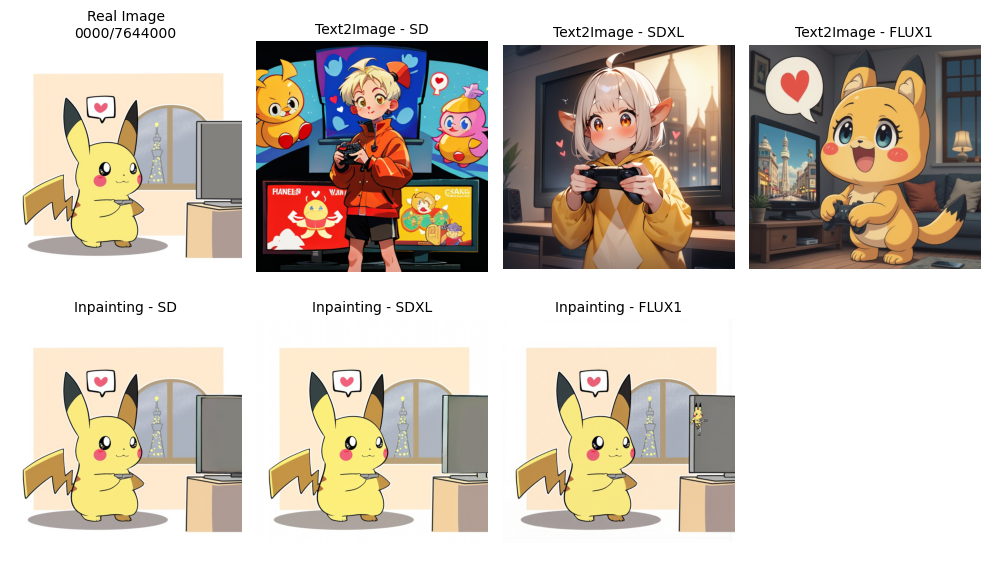

In [85]:
make_sample_grid(fake_root, real_root, collapsed_fake_img_dict)